In [1]:
!pip3 install keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from __future__ import print_function

import keras
from keras.callbacks import LearningRateScheduler as LRS

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD

from keras.preprocessing.image import ImageDataGenerator

In [4]:
batch_size = 100
num_classes = 10
epochs = 75

In [5]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)

# Mandatory to use ImageDataGenerator, it expects 4D Tensors
x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize [0..255]-->[0..1]
x_train /= 255
x_test /= 255

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
60000 train samples
10000 test samples


In [6]:
## Data Augmentation with an ImageGenerator
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False)

In [7]:
model = Sequential()
model.add(Reshape(target_shape=(784,), input_shape=(28,28,1)))
model.add(GN(0.1))

model.add(Dense(1024))
model.add(BN())
model.add(GN(0.2))
model.add(Activation('relu'))

model.add(Dense(1024))
model.add(BN())
model.add(GN(0.2))
model.add(Activation('relu'))

model.add(Dense(1024))
model.add(BN())
model.add(GN(0.2))
model.add(Activation('relu'))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 784)               0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              803840    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 1024)              0         
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1

In [8]:
sgd=SGD(lr=0.1, decay=0.0, momentum=0.0)

In [9]:
## define a learning rate scheduler
def scheduler(epoch):
    if epoch < 25:
        return .1
    elif epoch < 50:
        return 0.01
    else:
        return 0.001

set_lr = LRS(scheduler)
###

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [11]:
## Training, note the callbacks list
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[set_lr],
                            verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/75
600/600 [==============================] - 15s 22ms/step - loss: 0.5789 - accuracy: 0.8160 - val_loss: 0.1024 - val_accuracy: 0.9689
Epoch 2/75
600/600 [==============================] - 12s 21ms/step - loss: 0.1948 - accuracy: 0.9400 - val_loss: 0.0702 - val_accuracy: 0.9769
Epoch 3/75
600/600 [==============================] - 13s 21ms/step - loss: 0.1545 - accuracy: 0.9504 - val_loss: 0.0707 - val_accuracy: 0.9766
Epoch 4/75
600/600 [==============================] - 12s 21ms/step - loss: 0.1337 - accuracy: 0.9590 - val_loss: 0.0579 - val_accuracy: 0.9820
Epoch 5/75
600/600 [==============================] - 12s 21ms/step - loss: 0.1180 - accuracy: 0.9626 - val_loss: 0.0533 - val_accuracy: 0.9818
Epoch 6/75
600/600 [==============================] - 12s 20ms/step - loss: 0.1071 - accuracy: 0.9671 - val_loss: 0.0528 - val_accuracy: 0.9828
Epoch 7/75
600/600 [==============================] - 12s 21ms/step - loss: 0.0944 - accuracy: 0.9696 - val_loss: 0.0472 - val_accuracy:

In [12]:
## Test
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.024102460592985153
Test accuracy: 0.9923999905586243


In [13]:
import matplotlib.pyplot as plt


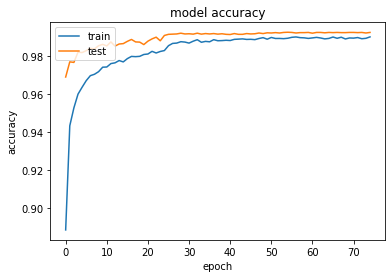

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
model.save_weights('./checkpoints/my_checkpoint')